In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
data/


In [0]:
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32
tfms = get_transforms(do_flip = False)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct(seed=2).label_from_func(lambda x: x))
data = (src.transform(size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))



In [4]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

#===================
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[:-2]))
        for param in resnet.parameters():
            param.requires_grad = False

        feature_extract = resnet

        ConcatPool2D = AdaptiveConcatPool2d()
        bottleneck = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Dropout(p=0.25, inplace=False),
        nn.Linear(in_features=1024, out_features=512, bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Dropout(p=0.25, inplace=False),
        #nn.Linear(in_features=512, out_features=3, bias=True),
        nn.Linear(in_features=512, out_features=3, bias=True)
        )

        self.encoder = nn.Sequential(
        feature_extract,
        ConcatPool2D,
        bottleneck)

        self.decoder = nn.Sequential(
            nn.Linear(in_features = 3, out_features = 512, bias = True),
            nn.ReLU(inplace = True),
            nn.Linear(in_features = 512, out_features = 2048, bias = True),
            #nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReLU(inplace = True)
            #nn.ConvTranspose2d(16, 128, kernel_size=8, stride=4),
            #nn.ReLU(inplace = True),
            #nn.ConvTranspose2d(128, 256, kernel_size=8, stride=4),
            #nn.ReLU(inplace = True),
            #nn.ConvTranspose2d(256, 1024, kernel_size=4, stride=1),
            #out features to twice the size of final image
            #nn.Linear(in_features = 1024, out_features = 448, bias = True),
            #nn.ReLU(inplace = True),
            #nn.Linear(in_features = 448, out_features = 64, bias = True),
            #nn.ConvTranspose2d(64, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        )

        self.upsampling = nn.Sequential(
            #nn.Upsample(scale_factor=2, mode='bilinear')
            nn.Upsample(scale_factor = 3.5, mode = 'bilinear'),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        #extracted = self.feature_extract(x)
        #encoded = self.encoder(extracted)
        #decoded = self.decoder(encoded)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = torch.reshape(decoded, (-1, 512, 2, 2))
        #decoded = torch.reshape(decoded, (1, 512, 512))
        decoded = self.upsampling(decoded)
        return decoded
        #return encoded, decoded



autoencoder = AutoEncoder();


Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:06<00:00, 14.5MB/s]


In [11]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[:-2]))
        for param in resnet.parameters():
            param.requires_grad = False

        feature_extract = resnet

        ConcatPool2D = AdaptiveConcatPool2d()

        self.encoder = nn.Sequential(
        feature_extract)
        #ConcatPool2D,
        #bottleneck)

        #self.decoder = nn.Sequential(
        #    nn.ReLU(inplace = True),
        #    nn.Linear(in_features = 3, out_features = 512, bias = True),
        #    nn.Linear(in_features = 512, out_features = 2048, bias = True),
        #    #nn.Upsample(scale_factor=2, mode='nearest'),
        #    #nn.ConvTranspose2d(16, 128, kernel_size=8, stride=4),
        #    nn.ReLU(inplace = True)
        #    #nn.ReLU(inplace = True),
        #    #nn.ConvTranspose2d(128, 256, kernel_size=8, stride=4),
            #nn.ReLU(inplace = True),
            #nn.ConvTranspose2d(256, 1024, kernel_size=4, stride=1),
            #out features to twice the size of final image
            #nn.Linear(in_features = 1024, out_features = 448, bias = True),
            #nn.ReLU(inplace = True),
            #nn.Linear(in_features = 448, out_features = 64, bias = True),
            #nn.ConvTranspose2d(64, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        #)

        self.upsampling = nn.Sequential(
            #nn.Upsample(scale_factor=2, mode='bilinear')
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace = True),
            nn.Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        #extracted = self.feature_extract(x)
        #encoded = self.encoder(extracted)
        #decoded = self.decoder(encoded)
        encoded = self.encoder(x)
        decoded = self.upsampling(encoded)
        #decoded = torch.reshape(decoded, (-1, 512, 2, 2))
        #decoded = torch.reshape(decoded, (1, 512, 512))
        #decoded = self.upsampling(decoded)
        return decoded
        #return encoded, decoded



autoencoder = AutoEncoder2();


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [12]:
summary(autoencoder.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn = Learner(data, autoencoder, loss_func=F.mse_loss);


In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.232995,#na#,00:48
1,0.230218,#na#,00:13
2,0.222504,#na#,00:14
3,0.202641,#na#,00:13
4,0.173103,#na#,00:13
5,0.143326,#na#,00:14
6,0.130351,#na#,00:13
7,0.168700,#na#,00:13


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


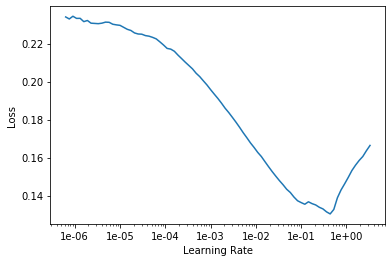

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(100, max_lr = 1e-02)

epoch,train_loss,valid_loss,time
0,0.158881,0.194489,00:30
1,0.132418,0.114152,00:19
2,0.113013,0.090286,00:18
3,0.094069,0.092060,00:18
4,0.078222,0.063868,00:18
5,0.065995,0.044876,00:18
6,0.057096,0.039258,00:18
7,0.050461,0.039890,00:18
8,0.045166,0.044724,00:18
9,0.041071,0.035667,00:18


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


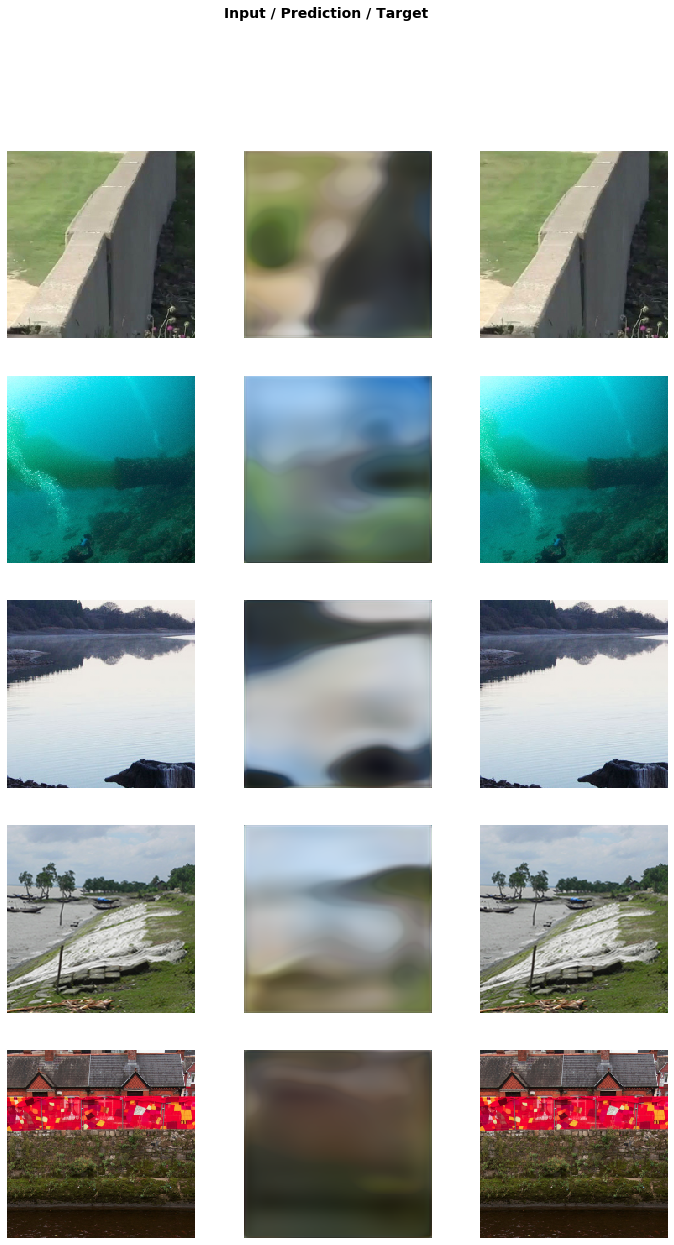

In [17]:
learn.show_results(ds_type=DatasetType.Valid)

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.011918,#na#,00:13
1,0.012000,#na#,00:14
2,0.011978,#na#,00:14
3,0.011942,#na#,00:13
4,0.011954,#na#,00:14
5,0.015032,#na#,00:13
6,0.027765,#na#,00:14


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 1.58E-05


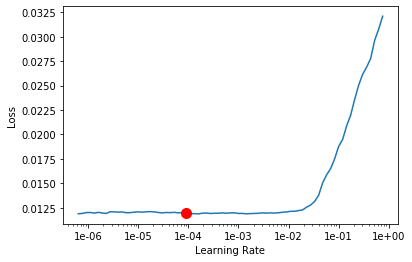

In [20]:
learn.recorder.plot(suggestion = True)

In [21]:
learn.fit_one_cycle(100, max_lr = 1e-04)

epoch,train_loss,valid_loss,time
0,0.012117,0.031052,00:18
1,0.012181,0.031004,00:18
2,0.012076,0.030937,00:18
3,0.012064,0.030932,00:18
4,0.012041,0.030991,00:18
5,0.012075,0.030877,00:18
6,0.012057,0.030924,00:18
7,0.012044,0.031028,00:19
8,0.012019,0.030994,00:18
9,0.012052,0.031004,00:18


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


KeyboardInterrupt: ignored

In [0]:
learn.save("partial_save")

In [0]:
learn.unfreeze()

In [25]:
learn.load("partial_save")

Learner(data=ImageDataBunch;

Train: LabelList (387 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Valid: LabelList (96 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Test: None, model=AutoEncoder2(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)


In [0]:
learn.unfreeze()

In [35]:
#learn.fit_one_cycle(10, max_lr = slice(1e-06, 1e-01))
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace=True)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace=True)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, mom